In [1]:
'''

+-------------------------------+
|                               |
|    I M P O R T   M O D E L    | 
|                               |
+-------------------------------+

Description

Creaged on Thu Aug 8 15:54 2022

@author: Xingyu Wu
'''

# --------------------------
# Importing public libraries
# --------------------------

# Operating system specific functions
import os

# Argument parser, for configuring the program execution
import argparse

# An object oriented library for handling EPANET files in Python
import epynet 

# yaml / yml configuration file support (a kind of language) 
# pip install pyyaml
import yaml

# PyTorch deep learning framework
import torch

# Import the networkx library
import networkx as nx

# Import Pandas for data handling
import pandas as pd

# Import numpy for array handling
import numpy as np

# Matplotlib for generating graphics
import matplotlib.pyplot as plt

# PyTorch from graph conversion tool
from torch_geometric.utils import from_networkx

# conda install pytorch-sparse -c pyg

# Train-test split with shuffle 
from sklearn.model_selection import train_test_split

import sys

/home/zczlx79/.conda/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --------------------------
# Importing custom libraries
# --------------------------

# Import a custom tool for converting EPANET .inp files to networkx graphs
from utils_pre.epanet_loader import get_nx_graph

# Function for visualisationa
from utils_pre.visualisation import visualise

# EPANET simulator, used to generate nodal pressures from the nominal model
from utils_pre.epanet_simulator import epanetSimulator

# SCADA timeseries dataloader
from utils_pre.data_loader import battledimLoader, dataCleaner, dataGenerator

# PyTorch early stopping callback
from utils_pre.early_stopping import EarlyStopping

# Metrics
from utils_pre.metrics import Metrics

## 1. Correlation between leaking pipe diameter and its own pipe diameter

### 1.1 loading leaking pipe information

In [3]:
config_path = './data/dataset_configuration.yaml'
try:
    with open(config_path,'r') as f:
        print('f', f)
        leak_pipes = yaml.load(f.read(),Loader=yaml.FullLoader)
except:
    print('"dataset_configuration" file not found.')
    sys.exit()

f <_io.TextIOWrapper name='./data/dataset_configuration.yaml' mode='r' encoding='UTF-8'>


In [4]:
leakages = leak_pipes['leakages']
leakages = leakages[1:]
df_leakage = pd.DataFrame(leakages)
column_names = {0:'linkID', 1:'startTime', 2:'endTime', 3:'leakDiameter (m)', 4:'leakType', 5:'peakTime'}
df_leakage = pd.concat([df_leakage.iloc[:, 0].str.split(', ', expand=True)], axis=1)
df_leakage.rename(columns = column_names, inplace = True)
df_leakage

,linkID,startTime,endTime,leakDiameter (m),leakType,peakTime
0,p257,2018-01-08 13:30,2019-12-31 23:55,0.011843,incipient,2018-01-25 08:30
1,p461,2018-01-23 04:25,2018-04-02 11:40,0.021320,incipient,2018-03-27 20:35
2,p232,2018-01-31 02:35,2018-02-10 09:20,0.020108,incipient,2018-02-03 16:05
3,p427,2018-02-13 08:25,2019-12-31 23:55,0.0090731,incipient,2018-05-14 19:25
4,p673,2018-03-05 15:45,2018-03-23 10:25,0.022916,abrupt,2018-03-05 15:45
5,p810,2018-07-28 03:05,2019-12-31 23:55,0.010028,incipient,2018-11-02 22:25
6,p628,2018-05-02 14:55,2018-05-29 21:20,0.022318,incipient,2018-05-16 08:00
7,p538,2018-05-18 08:35,2018-06-02 06:05,0.021731,abrupt,2018-05-18 08:35
8,p866,2018-06-01 09:05,2018-06-12 03:00,0.018108,abrupt,2018-06-01 09:05
9,p31,2018-06-28 10:35,2018-08-12 17:30,0.016389,incipient,2018-08-03 02:45


In [5]:
leakDiameter = df_leakage['leakDiameter (m)'].to_list()
leakDiameter = list(map(float, leakDiameter))
len(leakDiameter)

33

### 1.2 loading pipe diameter from .inp model

In [6]:
path_to_wdn = './data/L-TOWN_Real.inp' # Do I need to distinguish between REAL and NOMINAL EPANET inps here?

In [7]:
# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

In [29]:
wdn.pipes['p1'].diameter

198.6771

In [35]:
pipeDiameter = []
for i in range(len(leakDiameter)):
    pipe_name = df_leakage['linkID'][i]
    pipeDiameter.append(wdn.pipes[pipe_name].diameter)
len(pipeDiameter)
    

33

### 1.3 scatter plot and correlation

plot scatter plots of leaking diameters and pipe diameters


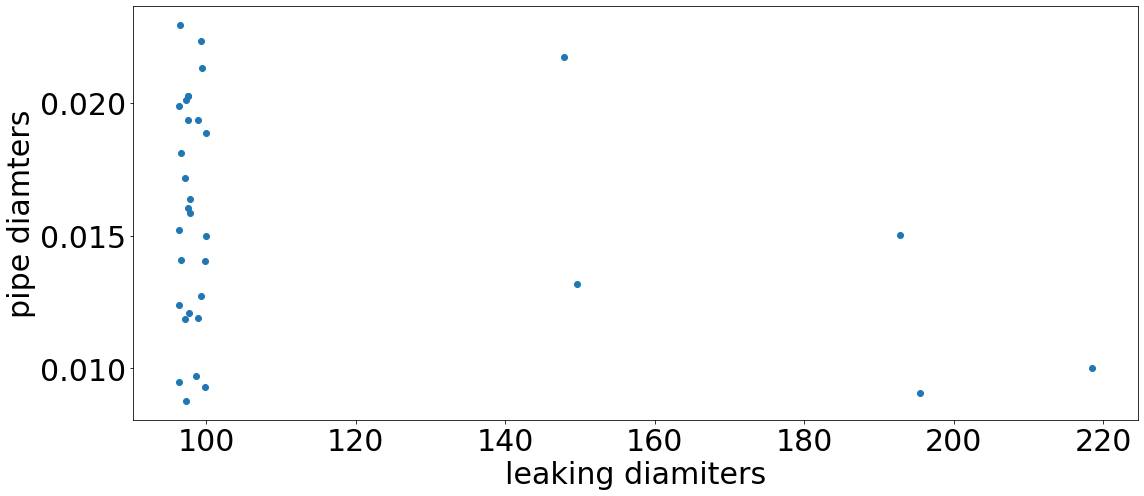

In [56]:
# plot scatter plots of AAPL Close and two kinds of share indexes.
print('plot scatter plots of leaking diameters and pipe diameters')
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 7))
ax1.scatter(pipeDiameter, leakDiameter)
ax1.set_xlabel(r'leaking diamiters', fontsize=30)
ax1.set_ylabel(r'pipe diamters', fontsize=30)
ax1.tick_params(labelsize=30)
plt.tight_layout()
# plt.savefig("./image/scatter.pdf")

In [59]:
np.corrcoef(leakDiameter, pipeDiameter) # pearsonr correlation matrix

array([[ 1.        , -0.26293334],
       [-0.26293334,  1.        ]])

相关系数＜0.4被认为相关性比较弱。

从线性和非线性相关系数来看，基本上没有相关性。

p值(不相关的概率) > 0.05, 没有理由认为显著性差异存在，即没有相关性。

In [58]:
from scipy.stats import pearsonr, spearmanr
print('linear correlation:', pearsonr(leakDiameter, pipeDiameter))
print('non-linear correlation:', spearmanr(leakDiameter, pipeDiameter))

linear correlation: (-0.26293334250121564, 0.13931368648100997)
non-linear correlation: SpearmanrResult(correlation=-0.13302139037433156, pvalue=0.4605299531844579)


## 2. Graph Visualization

### Environment Paths

In [4]:
path_to_wdn = './data/L-TOWN.inp' # Do I need to distinguish between REAL and NOMINAL EPANET inps here? 

### `EPANET` Model Import

In [5]:
# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

### `networkx` Graph Conversion

In [6]:
# edge_weight = 'unweighted'
# edge_weight = 'hydraulic_loss'
# edge_weight = 'log_hydraulic_loss'
# edge_weight = 'pruned'
edge_weight = 'pipe_length'
# edge_weight = 'inv_pipe_length'

In [7]:
# Convert the file using a custom function, based on:
# https://github.com/BME-SmartLab/GraphConvWat 
# G: Graph in nx format; pos: node position; head: hydraulic heads which not used in this project
G , pos , head = get_nx_graph(wdn, weight_mode = edge_weight, get_head=True)

In [23]:
# colormap  = (head - head.min()) / (head.max() - head.min()) # Try standard scaling
# # Generate a colormap
# cmap  = plt.get_cmap('hot')

# # Fit the datapoints to the colormap
# color = cmap(colormap)

# # Visualise the the model using our visualisation utility
# axis = visualise(G, pos=pos, color = color, edge_labels=True)
# plt.savefig('./figure/head.pdf')
# plt.show()

### Configuration File Import-->find the nodes with pressure sensor

In [24]:
'''
"dataset_configuration.yalm" :
Configuration file for generating the Historical (2018) and Evaluation (2019) datasets of the BattLeDIM competition.
Contains:
-file name of network
-dataset start and end times
-leakage information (link ID, start Time, end Time, leak Diameter (m), leak Type, peak Time)
-sensor locations (link or node IDs)
'''
print('Importing dataset configuration...\n')

# Open the dataset configuration file
with open('./data/dataset_configuration.yaml') as file:

    # Load the configuration to a dictionary
    config = yaml.load(file, Loader=yaml.FullLoader)

# Generate a list of integers, indicating the number of the node
# at which a  pressure sensor is present
sensors = [int(string.replace("n", "")) for string in config['pressure_sensors']]

Importing dataset configuration...



### Visualize pressure sensors

In [25]:
# print('Pressure sensors in the network are located at nodes: ')
# for each in sensors:
#     print('Node: \t {}'.format(each))

### Graph Visualisation

In [26]:
# Plot node with diff colors for with/without sensors
colormap = pd.Series([1.0 if i in sensors else 0.0 for i in range(1,G.number_of_nodes()+1)])

# Generate a colormap
cmap  = plt.get_cmap('coolwarm')

# Fit the datapoints to the colormap
color = cmap(colormap)

# Visualise the the model using our visualisation utility
# pipe_labels = 'pipe_name'
pipe_labels = 'pipe_weight'
axis = visualise(G, pos=pos, color = color, figsize = (60,32), edge_labels = pipe_labels)
plt.savefig('./figure/graph_edge_{}.pdf'.format(edge_weight))
plt.close() # close print figure here for saving super long ssh time

### Graph Measurements - two subgraphs

In [ ]:
# We may want to find the largest subgraph diameter
largest_subgraph_diameter = 0

# For each component of the imported network
for i,c in enumerate(nx.connected_components(G)):
    graph = G.subgraph(c)                       # Generate a subgraph
    diameter = nx.diameter(graph)               # Measure its diameter
    print("Subgraph's {} diameter: \t {}".format(i+1,diameter))
    if diameter > largest_subgraph_diameter:    # If it's the longest encountered
        diameter = largest_subgraph_diameter    # Store it  

Subgraph's 1 diameter: 	 20
Subgraph's 2 diameter: 	 79


## 3. Visulize Leakages in 2018 and 2019

### 2018

In [8]:
year = 2018
label_dir = './data/{}_Leakages.csv'.format(year)
df_label = pd.read_csv(label_dir, sep=';', decimal=',', index_col='Timestamp')
leakage_list = df_label.columns.tolist()
for node in G: # 782个节点
    for nbr in sorted(G.neighbors(node)): # 每个节点对应的邻居节点
        if G[node][nbr]['name'] in leakage_list:
            leakage_list.remove(G[node][nbr]['name'])
            print("leakage pipe {}'s nodes are: {} and {}.".format(G[node][nbr]['name'], node, nbr))

leakage pipe p31's nodes are: 40 and 42.
leakage pipe p461's nodes are: 106 and 484.
leakage pipe p538's nodes are: 147 and 531.
leakage pipe p232's nodes are: 184 and 191.
leakage pipe p628's nodes are: 197 and 590.
leakage pipe p673's nodes are: 206 and 623.
leakage pipe p158's nodes are: 232 and 235.
leakage pipe p183's nodes are: 299 and 305.
leakage pipe p866's nodes are: 311 and 758.
leakage pipe p427's nodes are: 340 and 462.
leakage pipe p257's nodes are: 350 and 351.
leakage pipe p369's nodes are: 422 and 423.
leakage pipe p654's nodes are: 609 and 610.
leakage pipe p810's nodes are: 716 and 717.


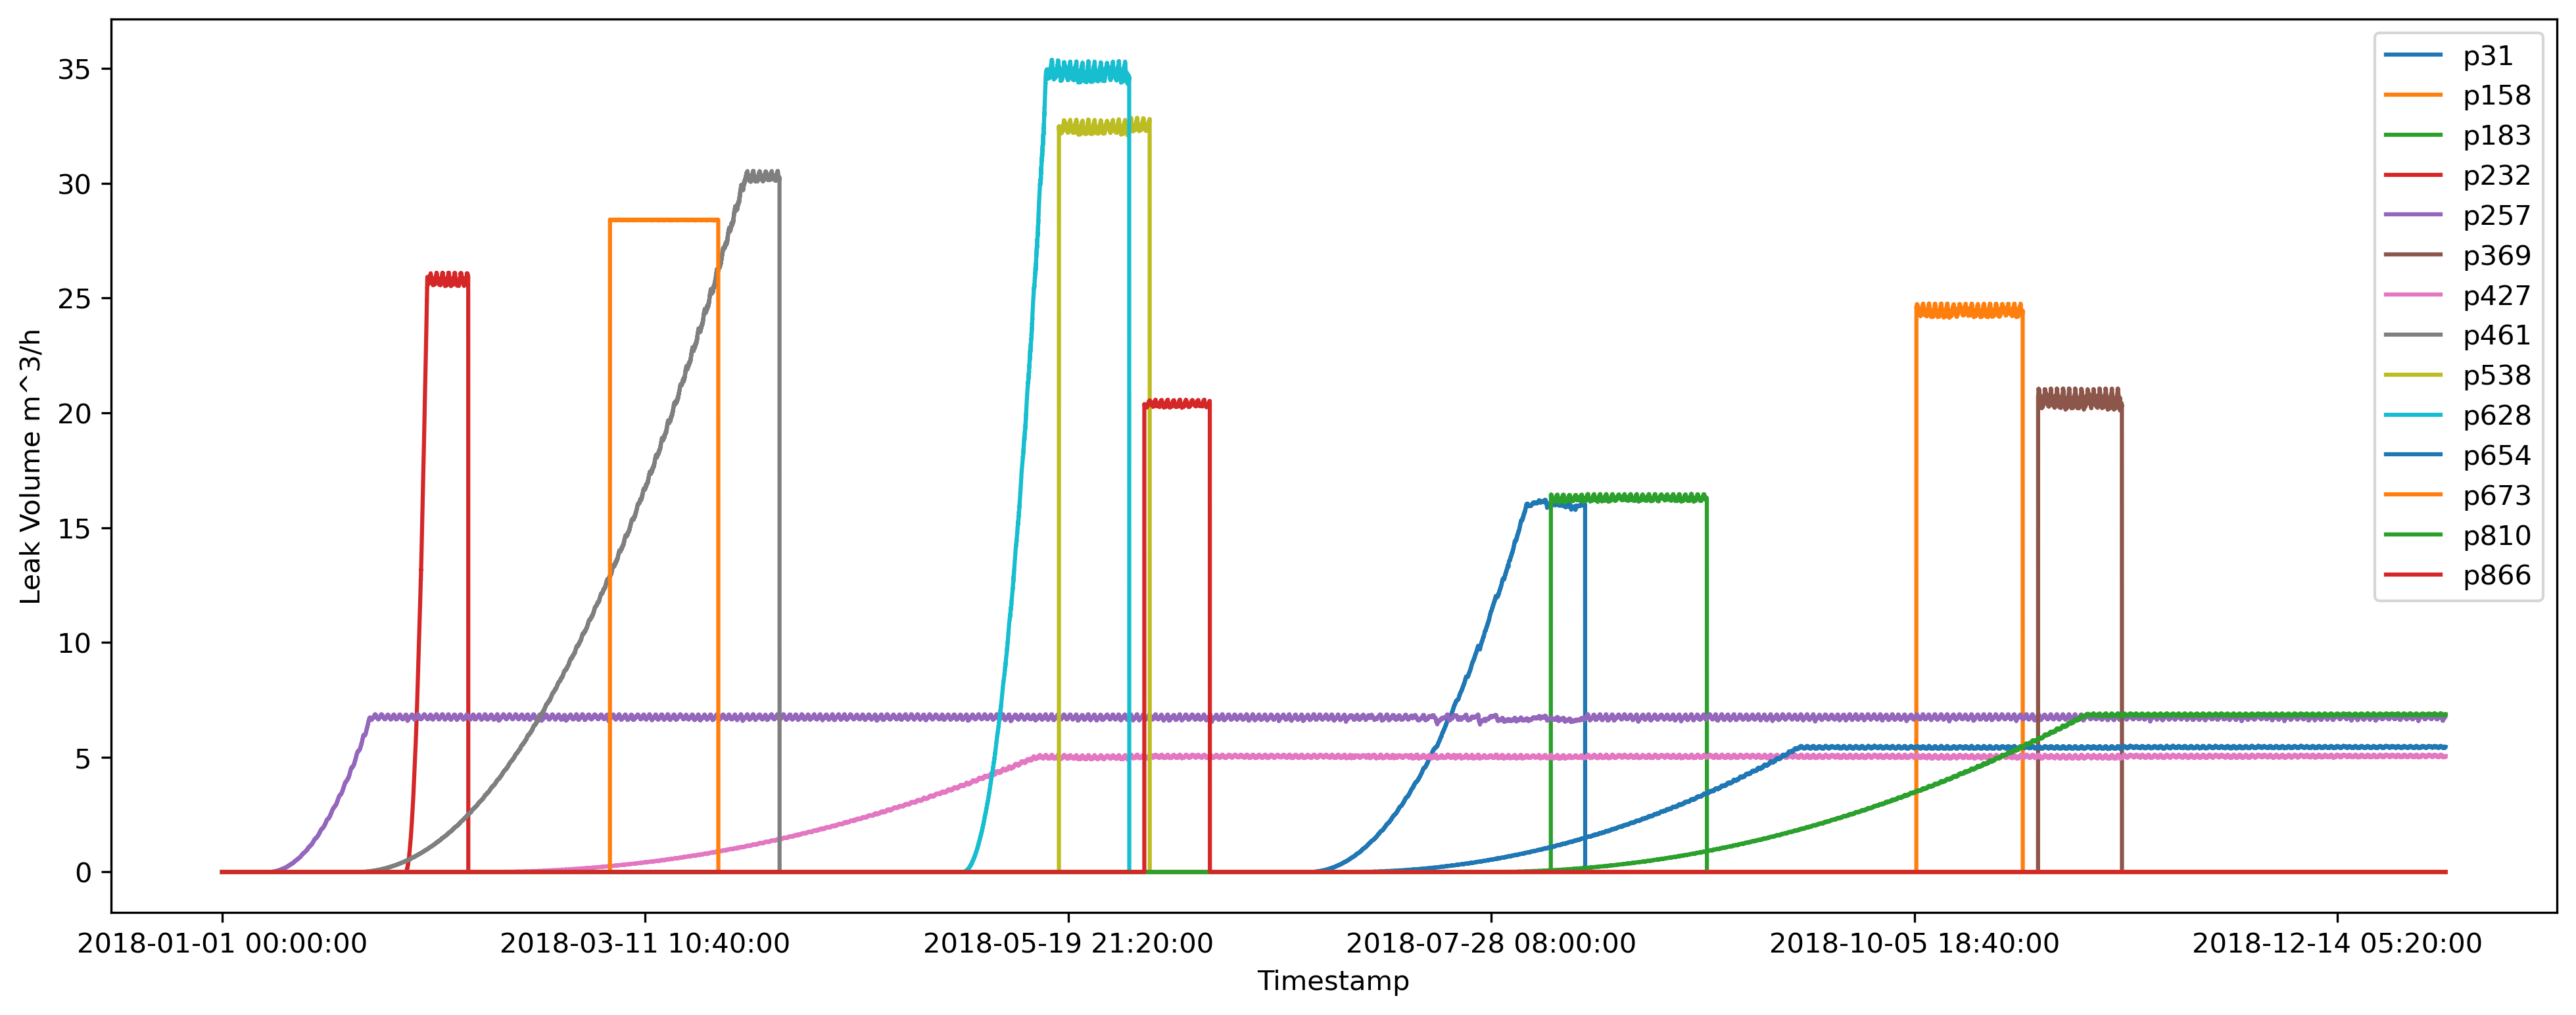

In [10]:
fig = plt.figure(figsize=(16,6),dpi=300)
df_label.plot(ax=plt.gca())
plt.ylabel('Leak Volume m^3/h')
plt.savefig('./figure/leakage_{}.pdf'.format(year))
# plt.close()

### 2019

In [16]:
year = 2019
label_dir = './data/{}_Leakages.csv'.format(year)
df_label = pd.read_csv(label_dir, sep=';', decimal=',', index_col='Timestamp')
leakage_list = df_label.columns.tolist()
for node in G: # 782个节点
    for nbr in sorted(G.neighbors(node)): # 每个节点对应的邻居节点
        if G[node][nbr]['name'] in leakage_list:
            leakage_list.remove(G[node][nbr]['name'])
            print("leakage pipe {}'s nodes are: {} and {}.".format(G[node][nbr]['name'], node, nbr))

leakage pipe p277's nodes are: 19 and 363.
leakage pipe p280's nodes are: 23 and 365.
leakage pipe p523's nodes are: 132 and 523.
leakage pipe p123's nodes are: 155 and 159.
leakage pipe p586's nodes are: 165 and 562.
leakage pipe p142's nodes are: 192 and 196.
leakage pipe p710's nodes are: 228 and 648.
leakage pipe p680's nodes are: 233 and 626.
leakage pipe p762's nodes are: 264 and 683.
leakage pipe p800's nodes are: 295 and 708.
leakage pipe p193's nodes are: 326 and 327.
leakage pipe p427's nodes are: 340 and 462.
leakage pipe p257's nodes are: 350 and 351.
leakage pipe p331's nodes are: 398 and 399.
leakage pipe p426's nodes are: 461 and 462.
leakage pipe p455's nodes are: 480 and 481.
leakage pipe p514's nodes are: 517 and 518.
leakage pipe p653's nodes are: 608 and 609.
leakage pipe p654's nodes are: 609 and 610.
leakage pipe p721's nodes are: 655 and 656.
leakage pipe p810's nodes are: 716 and 717.
leakage pipe p827's nodes are: 730 and 731.
leakage pipe p879's nodes are: 765

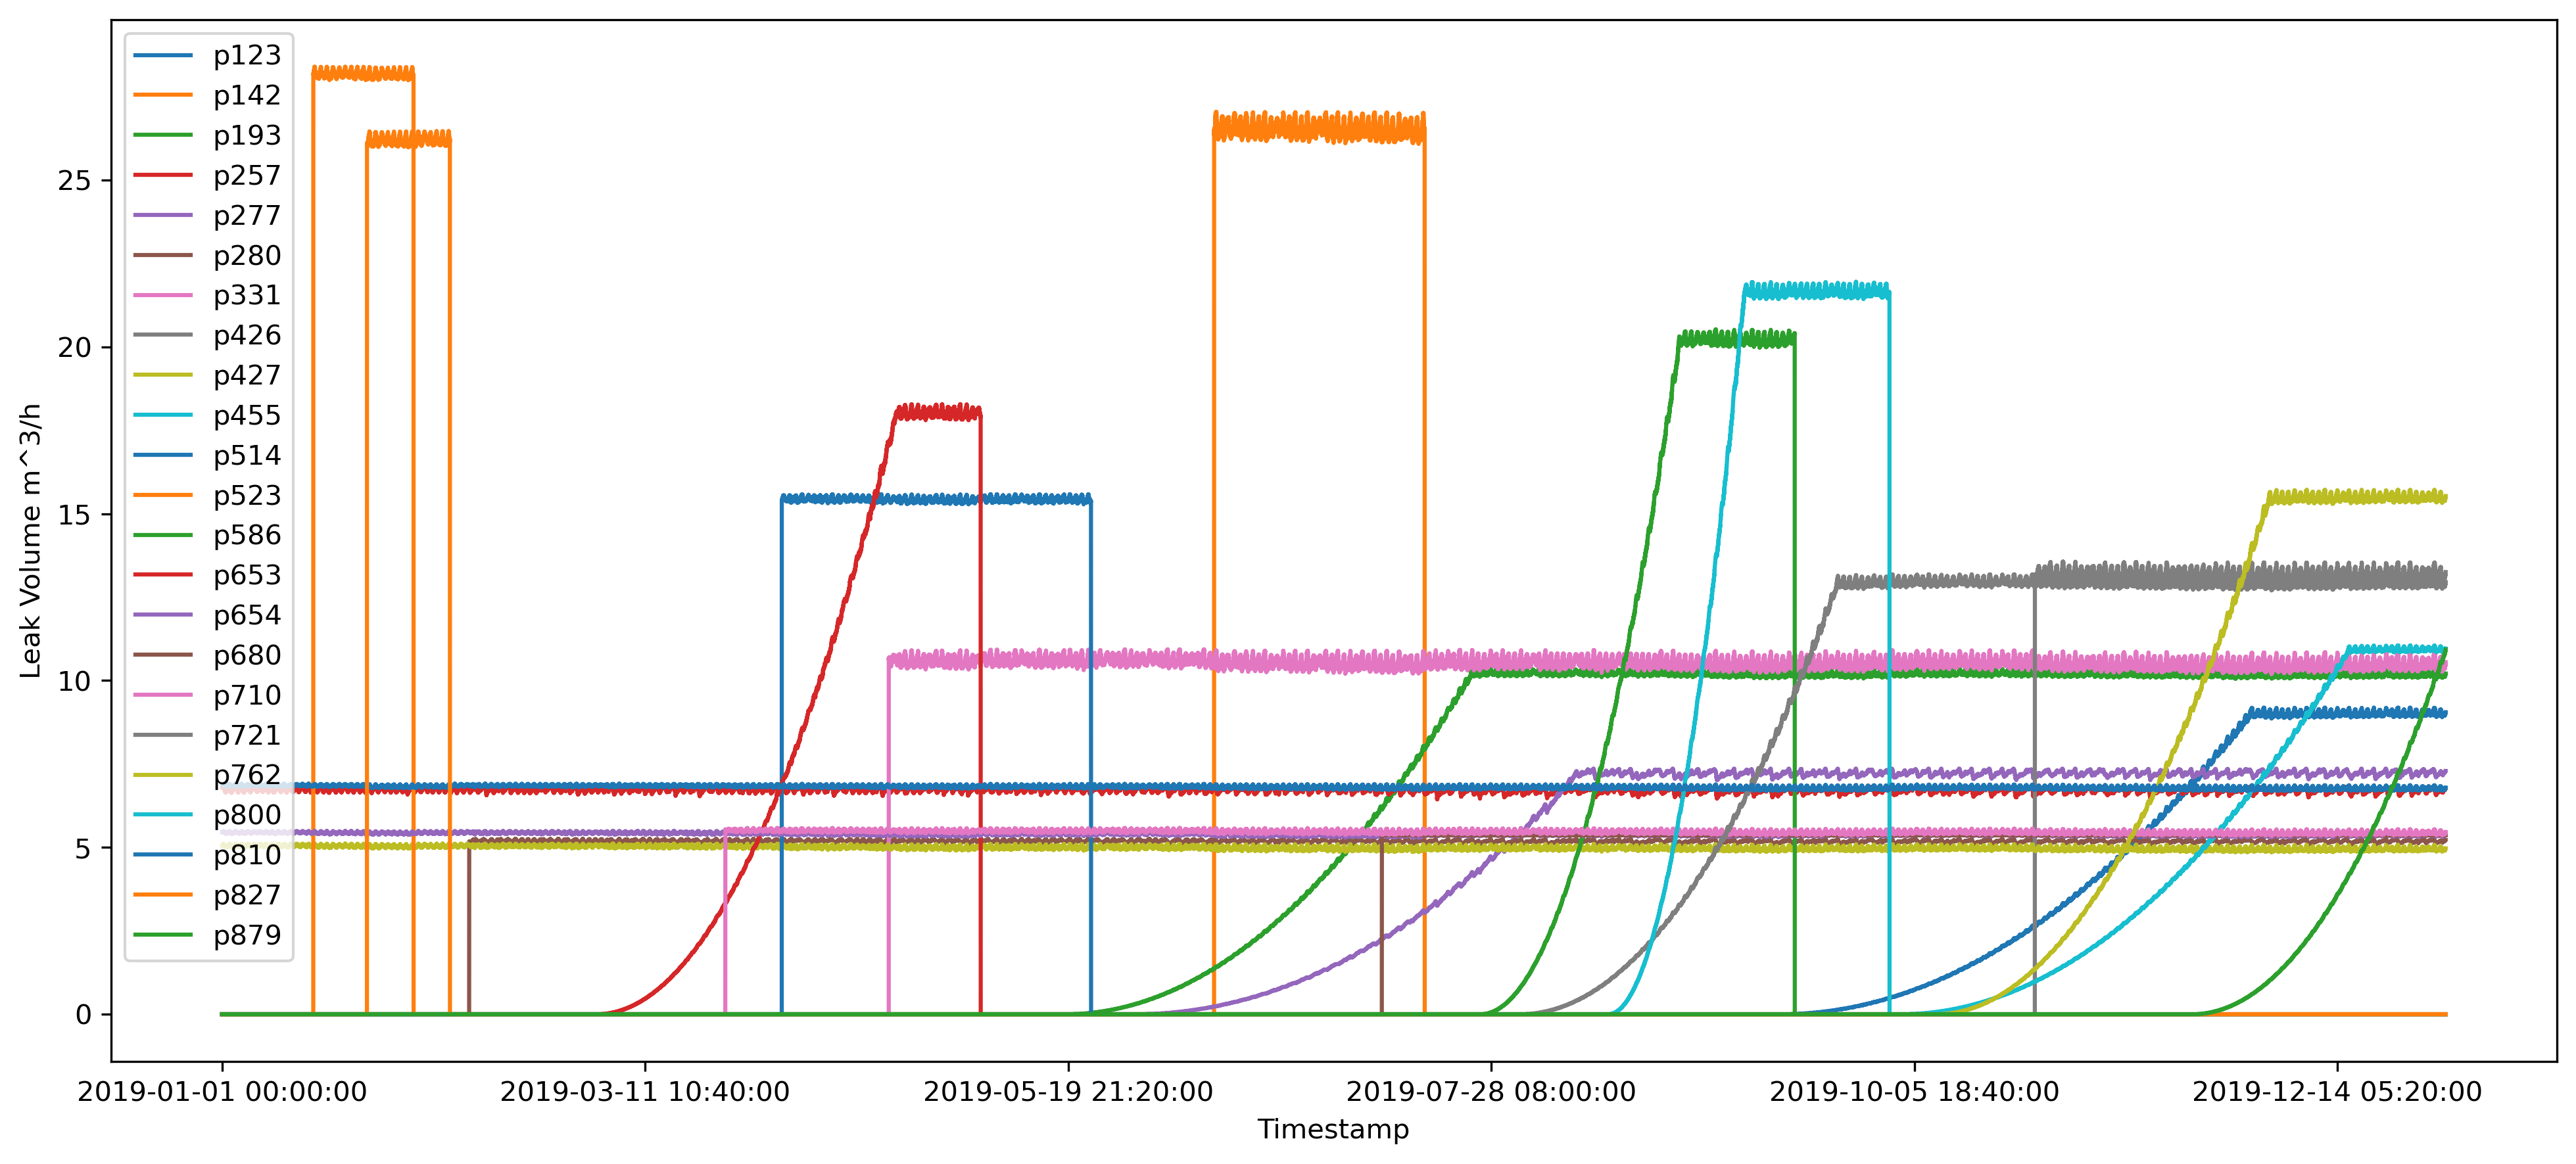

In [17]:
fig = plt.figure(figsize=(16,7),dpi=300)
df_label.plot(ax=plt.gca())
plt.ylabel('Leak Volume m^3/h')
plt.savefig('./figure/leakage_{}.pdf'.format(year))
plt.close()

## 4. Visulize Leakages nodes

### Reconstruction in 2018

In [37]:
# Runtime configuration
path_to_wdn     = './data/L-TOWN.inp'
path_to_data    = './data/l-town-data/'
scaling         = 'minmax'

# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

# Convert the file using a custom function, based on:
# https://github.com/BME-SmartLab/GraphConvWat 
G , pos , head = get_nx_graph(wdn, weight_mode = edge_weight, get_head=True)

# Instantiate the nominal WDN model
nominal_wdn_model = epanetSimulator(path_to_wdn, path_to_data)

# Run a simulation
nominal_wdn_model.simulate()

# Retrieve the nodal pressures
nominal_pressure = nominal_wdn_model.get_simulated_pressure()

# Run a simulation
nominal_wdn_model.simulate()

# Retrieve the nodal pressures
nominal_pressure = nominal_wdn_model.get_simulated_pressure()

# Open the dataset configuration file
with open(path_to_data + 'dataset_configuration.yml') as file:

    # Load the configuration to a dictionary
    config = yaml.load(file, Loader=yaml.FullLoader) 

# Generate a list of integers, indicating the number of the node
# at which a  pressure sensor is present
sensors = [int(string.replace("n", "")) for string in config['pressure_sensors']]

x,y,scale,bias = dataCleaner(pressure_df    = nominal_pressure, # Pass the nodal pressures
                                observed_nodes = sensors,          # Indicate which nodes have sensors
                                rescale        = scaling)          # Perform scaling on the timeseries data

def read_prediction(filename='predictions.csv', scale=1, bias=0, start_date='2018-01-01 00:00:00'):
    df = pd.read_csv(filename, index_col='Unnamed: 0', error_bad_lines=False)
    df.columns = ['n{}'.format(int(node)+1) for node in df.columns]
    df = df*scale+bias
    df.index = pd.date_range(start=start_date,
                             periods=len(df),
                             freq = '5min')
    return df

r18 = read_prediction(filename='./data/reconstruction/2018_reconstructions.csv',
                      scale=scale,
                      bias=bias,
                      start_date='2018-01-01 00:00:00')

/home/zczlx79/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




### Pressure Observations (33 sensors) in 2018

In [40]:
pressure_dir = './data/2018_SCADA_Pressures.csv'
df_pressure_2018 = pd.read_csv(pressure_dir, sep=';', decimal=',', index_col='Timestamp')

### Leakages in 2018

In [41]:
year = 2018
label_dir = './data/{}_Leakages.csv'.format(year)
df_label = pd.read_csv(label_dir, sep=';', decimal=',', index_col='Timestamp')

In [15]:
# leakage pipe p31's nodes are: 40 and 42.
# leakage pipe p461's nodes are: 106 and 484.
# leakage pipe p538's nodes are: 147 and 531.
# leakage pipe p232's nodes are: 184 and 191.
# leakage pipe p628's nodes are: 197 and 590.
# leakage pipe p673's nodes are: 206 and 623.
# leakage pipe p158's nodes are: 232 and 235.
# leakage pipe p183's nodes are: 299 and 305.
# leakage pipe p866's nodes are: 311 and 758.
# leakage pipe p427's nodes are: 340 and 462.
# leakage pipe p257's nodes are: 350 and 351.
# leakage pipe p369's nodes are: 422 and 423.
# leakage pipe p654's nodes are: 609 and 610.
# leakage pipe p810's nodes are: 716 and 717.

### Index to datetime

In [42]:
df_pressure_2018.index = pd.to_datetime(df_pressure_2018.index)
r18.index = pd.to_datetime(r18.index)
df_label.index = pd.to_datetime(df_label.index)

### r18 -> mean = 0

In [63]:
window  = '1d'   # Set the window size 'm'
r_m_avg = r18.rolling(window).mean()   
r_m_avg -= r_m_avg.mean()       

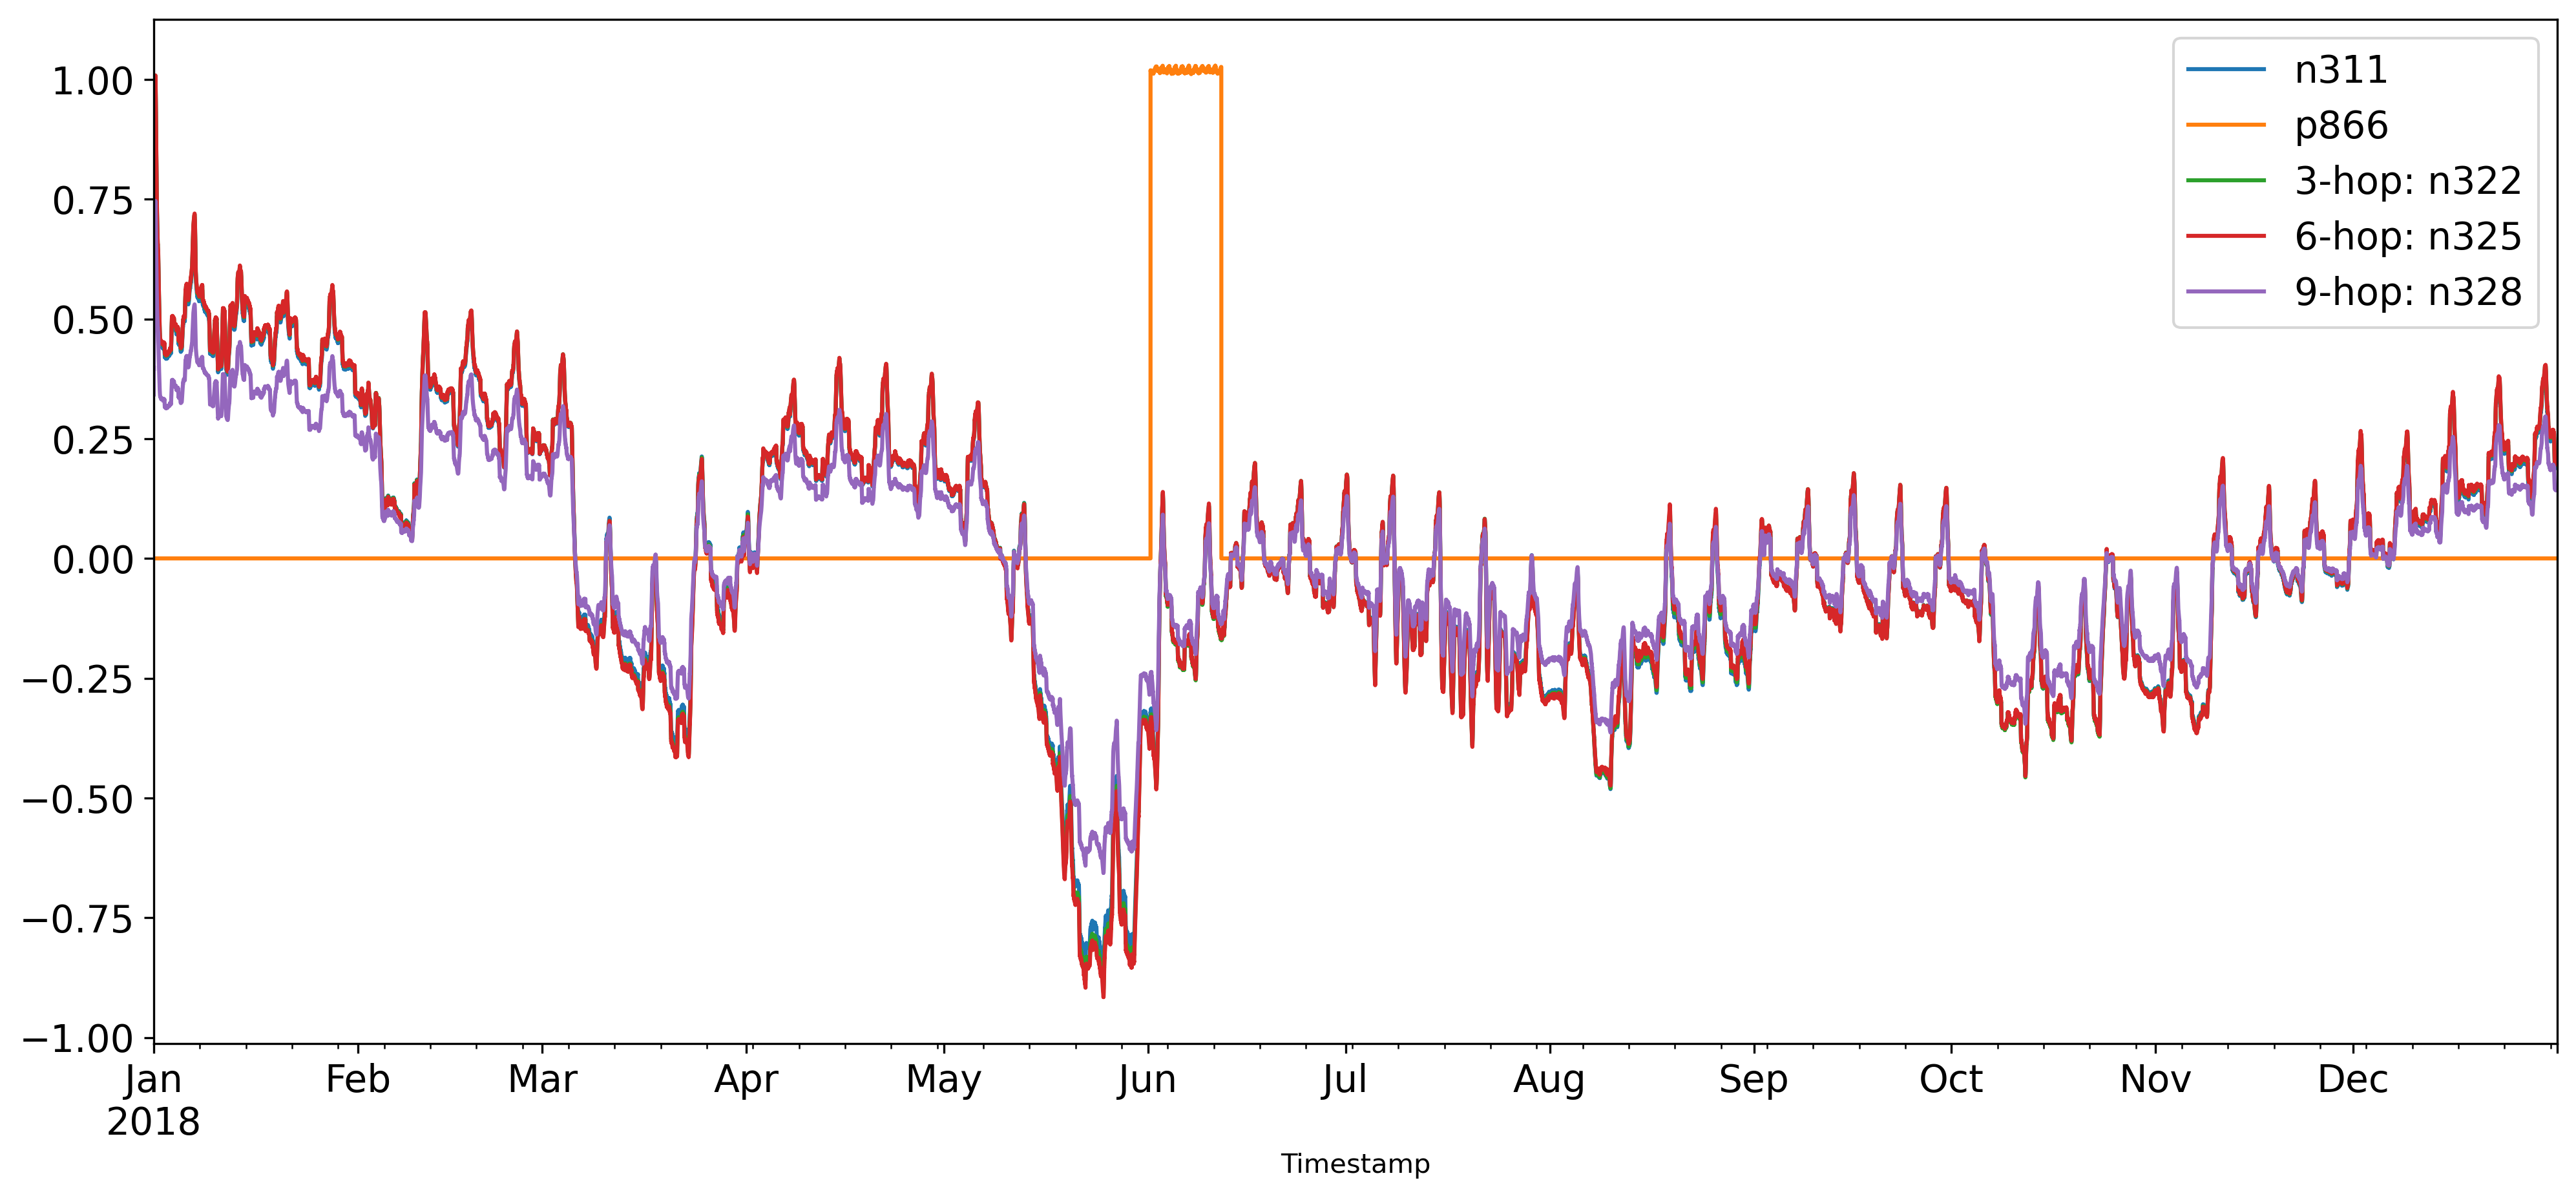

In [79]:
# leakage pipe p866's nodes are: 311 and 758.
node_sensor = ['n311']
fig = plt.figure(figsize=(16,7),dpi=300)
for node in node_sensor:
    r_m_avg[node].plot(label=node)
(0.05*df_label['p866']).plot(ax=plt.gca())
# 3-order n322
n3 = 'n322'
r_m_avg[n3].plot(label='3-hop: {}'.format(n3))
# 6-order n291
n6 = 'n325'
r_m_avg[n6].plot(label='6-hop: {}'.format(n6))
# 9-order n701
n9 = 'n328'
r_m_avg[n9].plot(label='9-hop: {}'.format(n9))
plt.legend(fontsize = 14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.savefig('./figure/leakage_p866.pdf')